In [ ]:
!pip install regressors

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from regressors import stats
import seaborn as sns
import pandas as pd
import numpy as np
import regressors

sns.set(style='whitegrid', context='notebook')

## Descargando los datos

In [ ]:
df = pd.read_csv('data/insurance.csv')
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

In [ ]:
print(df.shape)
df.charges.hist(bins = 40)

(1338, 7)


<AxesSubplot:>

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [ ]:
df[df.charges>50000]
df = df[df.charges<50000]

## Viendo correlaciones
Ahora entendamos nuestros datos viendo cómo se distribuyen y correlacionan. 

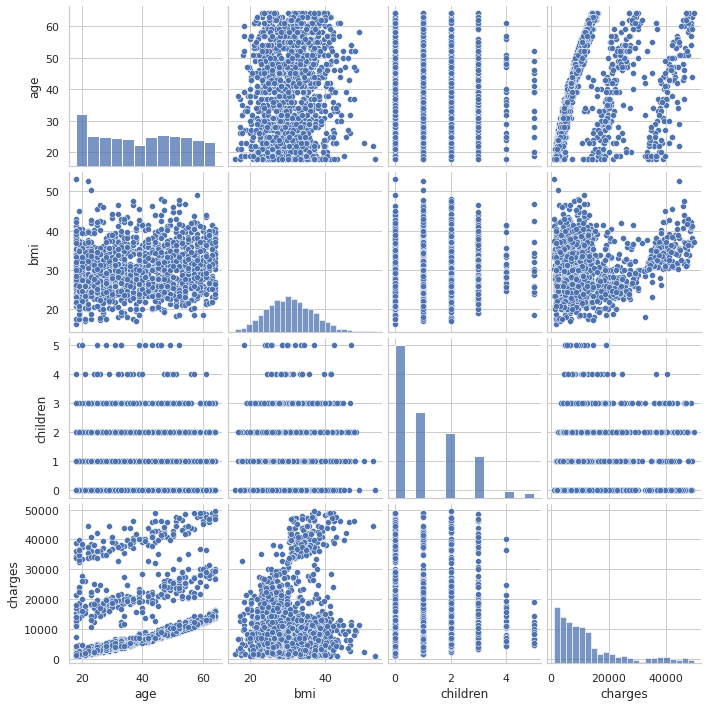

In [ ]:
sns.pairplot(df, height=2.5)
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

In [ ]:
numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols,xticklabels=numeric_cols)

<AxesSubplot:>

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función **[get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)** de pandas.

In [ ]:
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df.head()

age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400         0           1                 0   
1   18  33.770         1   1725.55230         1           0                 0   
2   28  33.000         3   4449.46200         1           0                 0   
3   33  22.705         0  21984.47061         1           0                 1   
4   32  28.880         0   3866.85520         1           0                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0

## Creando modelos 
Primero se usará un modelo con todas las variables.

In [ ]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X = df[X_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [ ]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.7436
mse:  0.2568


In [ ]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min      1Q  Median     3Q    Max
-1.8479 -0.1008  0.1008 0.2742 0.9303


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept        0.007770    0.027923   0.2783  0.780972
region_southwest -0.041265    0.033568  -1.2293  0.219834
sex_male          0.000847    0.028001   0.0302  0.975890
bmi               0.169380    0.027152   6.2383  0.000000
region_southeast -0.040243    0.033323  -1.2076  0.228042
region_northwest -0.016802    0.030989  -0.5422  0.588053
smoker_yes        0.799879    0.027322  29.2759  0.000000
children          0.050592    0.028970   1.7464  0.081668
age               0.305307    0.028162  10.8411  0.000000
---
R-squared:  0.74357,    Adjusted R-squared:  0.73724
F-statistic: 117.44 on 8 features


In [ ]:
# Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [ ]:
df_second = df.copy()
df_second['age2'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes

Analizando el segundo modelo

In [ ]:
# X_cols = list(set(df.columns)-set(['charges']))
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children']
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.9163
mse:  0.0816


In [ ]:
# model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median     3Q    Max
-1.6805 0.0798  0.1154 0.1362 0.3199


Coefficients:
                   Estimate  Std. Error  t value  p value
_intercept         0.000000    0.015663   0.0000  1.00000
sobrepeso*fumador  0.496820    0.019979  24.8667  0.00000
smoker_yes         0.447994    0.020280  22.0900  0.00000
age2               0.324667    0.015595  20.8191  0.00000
children           0.068231    0.015780   4.3238  0.00002
---
R-squared:  0.91626,    Adjusted R-squared:  0.91524
F-statistic: 897.27 on 4 features


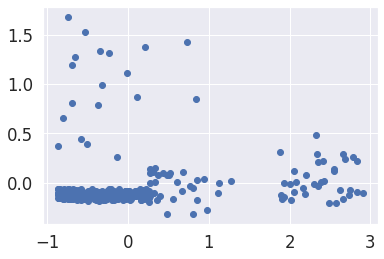

In [ ]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=183a4102-ed36-4d8f-a68e-0f907c31c07b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>